# CLIP Implementation with Memory Optimization

This notebook implements a memory-efficient version of CLIP (Contrastive Language-Image Pre-training) for zero-shot image classification.

In [5]:
# Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights  # Using ResNet18 instead of 50
from transformers import GPT2Tokenizer, GPT2Model
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler
import gc

# Set style for plots
plt.style.use('seaborn')
sns.set_theme()


## Memory Management and Device Setup

In [6]:
# Set device and memory management
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    # Clear cache
    torch.cuda.empty_cache()
    gc.collect()
    
    # Print GPU info
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
    print(f"Memory Cached: {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")

Using device: cuda
GPU: NVIDIA GeForce RTX 2080 Ti
Memory Allocated: 0.00 MB
Memory Cached: 0.00 MB


## Data Preparation

In [7]:
# Image preprocessing with smaller size
transform = transforms.Compose([
    transforms.Resize(128),  # Smaller size than 224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

Files already downloaded and verified
Files already downloaded and verified
Training samples: 50000
Test samples: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Model Architecture

In [8]:
class ImageEncoder(nn.Module):
    def __init__(self, mode='finetune'):
        super().__init__()
        weights = ResNet18_Weights.IMAGENET1K_V1
        self.resnet = resnet18(weights=weights)
        
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1))

    def forward(self, x):
        x = self.resnet(x)
        x = self.adaptive_pool(x)
        x = torch.reshape(x, (x.shape[0], x.shape[1]))
        return x

class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = GPT2Tokenizer.from_pretrained('openai-community/gpt2')
        self.model = GPT2Model.from_pretrained('openai-community/gpt2')
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def forward(self, texts):
        inputs = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=32)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.cuda.amp.autocast():
            outputs = self.model(**inputs)
        return outputs.last_hidden_state[:, -1, :]

class CLIP(nn.Module):
    def __init__(self, embedding_dim=256):  # Reduced from 512
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        
        # Projection layers (ResNet18 outputs 512-dim)
        self.image_projection = nn.Linear(512, embedding_dim)
        self.text_projection = nn.Linear(768, embedding_dim)
        
        # Additional linear layers
        self.image_layer1 = nn.Linear(embedding_dim, embedding_dim)
        self.text_layer1 = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, image, text):
        with torch.cuda.amp.autocast():
            image_embedding = self.image_encoder(image)
            text_embedding = self.text_encoder(text)
            
            image_embedding = self.image_projection(image_embedding)
            image_embedding = self.image_layer1(image_embedding)
            
            text_embedding = self.text_projection(text_embedding)
            text_embedding = self.text_layer1(text_embedding)
            
            # Normalize embeddings
            image_embedding = F.normalize(image_embedding, p=2, dim=-1)
            text_embedding = F.normalize(text_embedding, p=2, dim=-1)
            
        return image_embedding, text_embedding

## Training Utilities

In [9]:
def train_one_epoch(model, dataloader, optimizer, scaler, embedding_queue=None, use_triplet_loss=False, accumulation_steps=4):
    model.train()
    total_loss = 0
    margin = 0.2
    optimizer.zero_grad()
    
    pbar = tqdm(dataloader, desc='Training', leave=False)
    
    for batch_idx, (images, labels) in enumerate(pbar):
        images = images.to(device)
        texts = [f"This is an image of a {train_dataset.classes[label]}" for label in labels]
        
        with torch.cuda.amp.autocast():
            img_emb, text_emb = model(images, texts)
            
            if use_triplet_loss:
                img_text_similarity = torch.matmul(img_emb, text_emb.t()).diag()
                n = img_emb.shape[0]
                original_list = list(range(n))
                shifted_list = original_list[1:] + [original_list[0]]
                shuffled_image = img_emb[shifted_list]
                shuffled_text = text_emb[shifted_list]
                neg_sim_img = torch.matmul(img_emb, shuffled_text.t()).diag()
                neg_sim_text = torch.matmul(text_emb, shuffled_image.t()).diag()
                img_loss = torch.clamp(margin + neg_sim_img - img_text_similarity, min=0)
                text_loss = torch.clamp(margin + neg_sim_text - img_text_similarity, min=0)
                loss = (img_loss.mean() + text_loss.mean())/2
            else:
                if embedding_queue is not None:
                    embedding_queue.add_queue(img_emb.clone().detach().cpu(), text_emb.clone().detach().cpu())
                    saved_img_embeddings, saved_text_embeddings = embedding_queue.return_values()
                    
                    if len(saved_img_embeddings) > 0:
                        new_img = torch.cat(saved_img_embeddings, dim=0).to(device)
                        new_text = torch.cat(saved_text_embeddings, dim=0).to(device)
                        img_mat = torch.cat([img_emb, new_img], dim=0)
                        text_mat = torch.cat([text_emb, new_text], dim=0)
                    else:
                        img_mat = img_emb
                        text_mat = text_emb
                else:
                    img_mat = img_emb
                    text_mat = text_emb
                
                labels = torch.arange(img_emb.shape[0]).to(device)
                logits_img_text = torch.matmul(img_emb, text_mat.t()) * 2
                logits_text_img = torch.matmul(text_emb, img_mat.t()) * 2
                
                img_text_loss = F.cross_entropy(logits_img_text, labels)
                text_img_loss = F.cross_entropy(logits_text_img, labels)
                loss = (img_text_loss + text_img_loss)/2
            
            loss = loss / accumulation_steps
        
        scaler.scale(loss).backward()
        
        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        total_loss += loss.item() * accumulation_steps
        pbar.set_postfix({'loss': f'{loss.item() * accumulation_steps:.4f}'})
        
        # Clear some memory
        del img_emb, text_emb, loss
        if batch_idx % 10 == 0:
            torch.cuda.empty_cache()
    
    return total_loss / len(dataloader)

@torch.no_grad()
def evaluate(model, dataset, batch_size=32):  # Reduced batch size
    model.eval()
    correct = 0
    total = 0
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    pbar = tqdm(dataloader, desc='Evaluating', leave=False)
    
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        class_texts = [f"This is an image of a {dataset.classes[i]}" 
                      for i in range(len(dataset.classes))]
        
        with torch.cuda.amp.autocast():
            img_emb, _ = model(images, class_texts)
            _, text_emb = model(images[0:1], class_texts)
            
            similarity = torch.matmul(img_emb, text_emb.t())
            predictions = similarity.argmax(dim=1)
        
        batch_correct = (predictions == labels).sum().item()
        correct += batch_correct
        total += labels.size(0)
        
        pbar.set_postfix({'accuracy': f'{100 * batch_correct / labels.size(0):.2f}%'})
        
        # Clear some memory
        del img_emb, text_emb, similarity, predictions
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return correct / total * 100

In [10]:
class EmbeddingQueue:
    def __init__(self, max_size=15):
        self.max_size = max_size
        self.image_queue = []
        self.text_queue = []
    
    def add_queue(self, image_embedding, text_embedding):
        """Add new embeddings to queue and maintain max size"""
        self.image_queue.append(image_embedding)
        self.text_queue.append(text_embedding)
        
        # Remove oldest embeddings if queue exceeds max size
        if len(self.image_queue) > self.max_size:
            self.image_queue.pop(0)
            self.text_queue.pop(0)
    
    def return_values(self):
        """Return stored embeddings"""
        return self.image_queue, self.text_queue
    
    def clear(self):
        """Clear all stored embeddings"""
        self.image_queue = []
        self.text_queue = []

In [11]:
# First ensure we have the necessary imports
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics(train_losses, accuracies):
    """
    Plot training loss and accuracy metrics
    Args:
        train_losses (list): List of training losses per epoch
        accuracies (list): List of accuracy values per epoch
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training loss
    ax1.plot(train_losses, 'b-', label='Training Loss')
    ax1.set_title('Training Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(accuracies, 'r-', label='Accuracy')
    ax2.set_title('Model Accuracy Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()



## Training Loop

In [12]:
def main():
    # Hyperparameters
    batch_size = 32  # Reduced from 64
    epochs = 5
    learning_rate = 1e-4
    embedding_dim = 256  # Reduced from 512
    use_queue = True
    use_triplet_loss = False
    accumulation_steps = 4  # Gradient accumulation steps
    
    print("Initializing model...")
    model = CLIP(embedding_dim=embedding_dim).to(device)
    
    # Initialize queue if using it
    embedding_queue = EmbeddingQueue(max_size=15) if use_queue else None  # Reduced queue size
    
    # Setup optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    scaler = GradScaler()
    
    # Create data loader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                             shuffle=True, num_workers=0)
    
    # Lists to store metrics
    train_losses = []
    accuracies = []
    
    print("Starting training...")
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Train
        train_loss = train_one_epoch(model, train_loader, optimizer, scaler,
                                    embedding_queue, use_triplet_loss, accumulation_steps)
        scheduler.step()
        
        # Evaluate
        accuracy = evaluate(model, test_dataset)
        
        # Store metrics
        train_losses.append(train_loss)
        accuracies.append(accuracy)
        
        print(f"Training Loss: {train_loss:.4f}")
        print(f"Test Accuracy: {accuracy:.2f}%")
        print("-" * 50)
        
        # Plot current progress
        plot_metrics(train_losses, accuracies)
        
        # Clear memory
        torch.cuda.empty_cache()
        gc.collect()
    
    return model, train_losses, accuracies

Initializing model...
Starting training...

Epoch 1/5


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training Loss: 5.4428
Test Accuracy: 73.79%
--------------------------------------------------


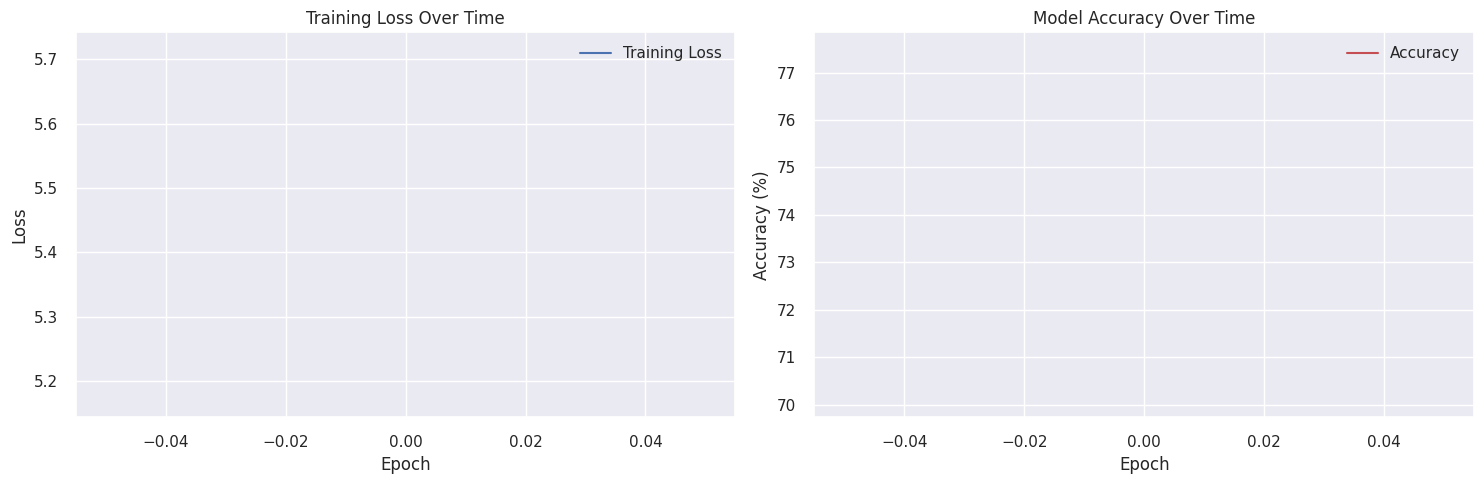


Epoch 2/5


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training Loss: 4.9949
Test Accuracy: 86.70%
--------------------------------------------------


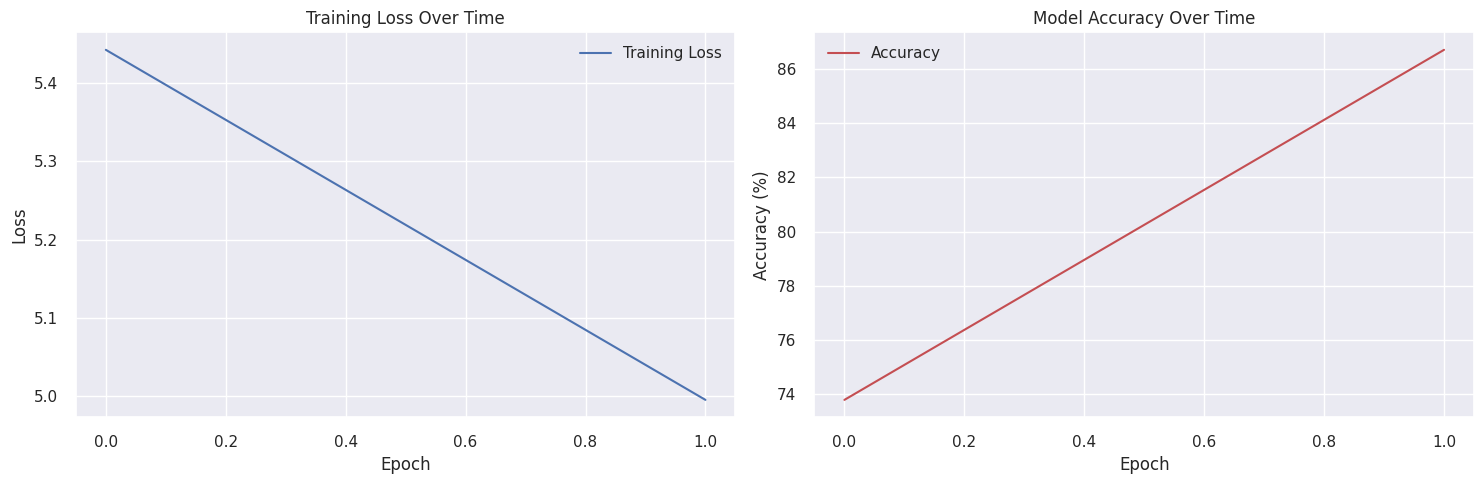


Epoch 3/5


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training Loss: 4.8594
Test Accuracy: 91.75%
--------------------------------------------------


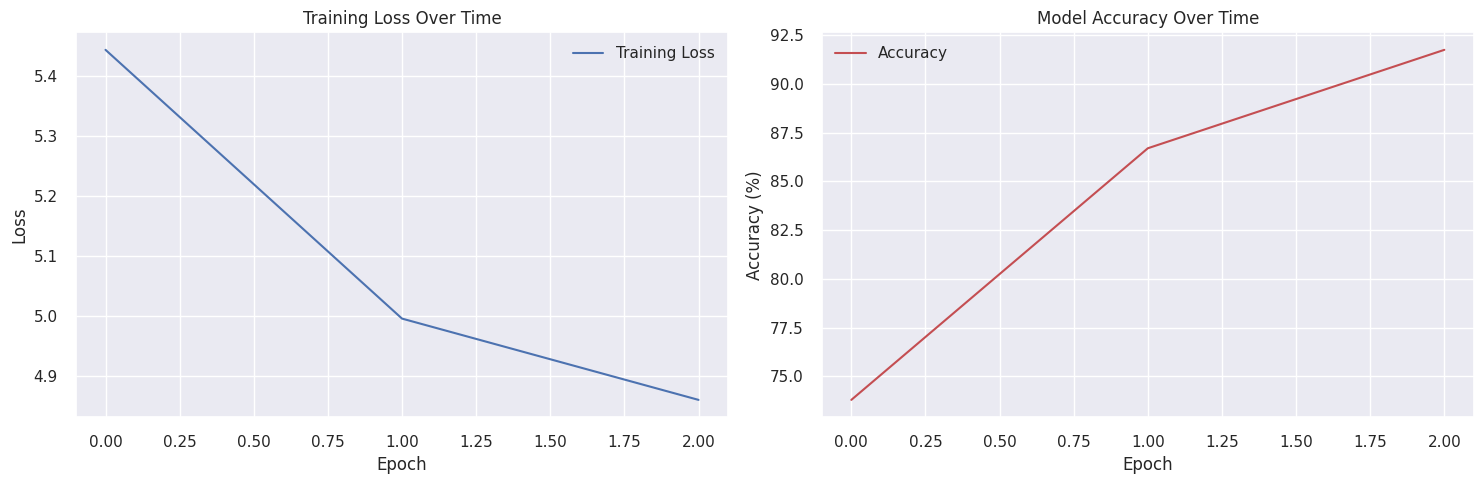


Epoch 4/5


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training Loss: 4.7793
Test Accuracy: 93.58%
--------------------------------------------------


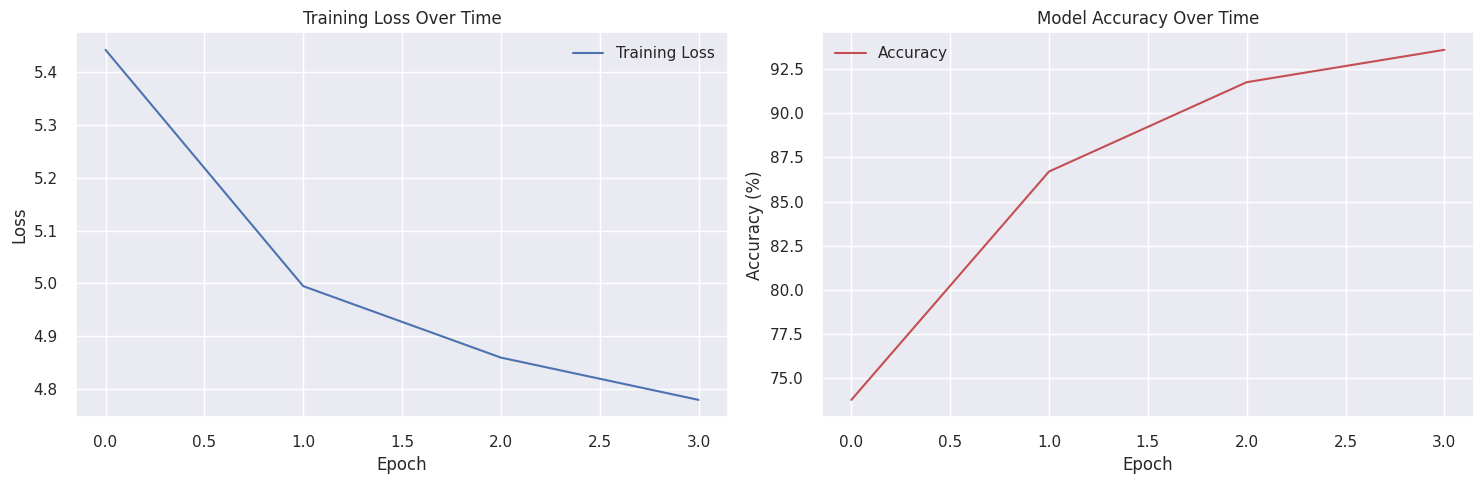


Epoch 5/5


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training Loss: 4.7455
Test Accuracy: 93.95%
--------------------------------------------------


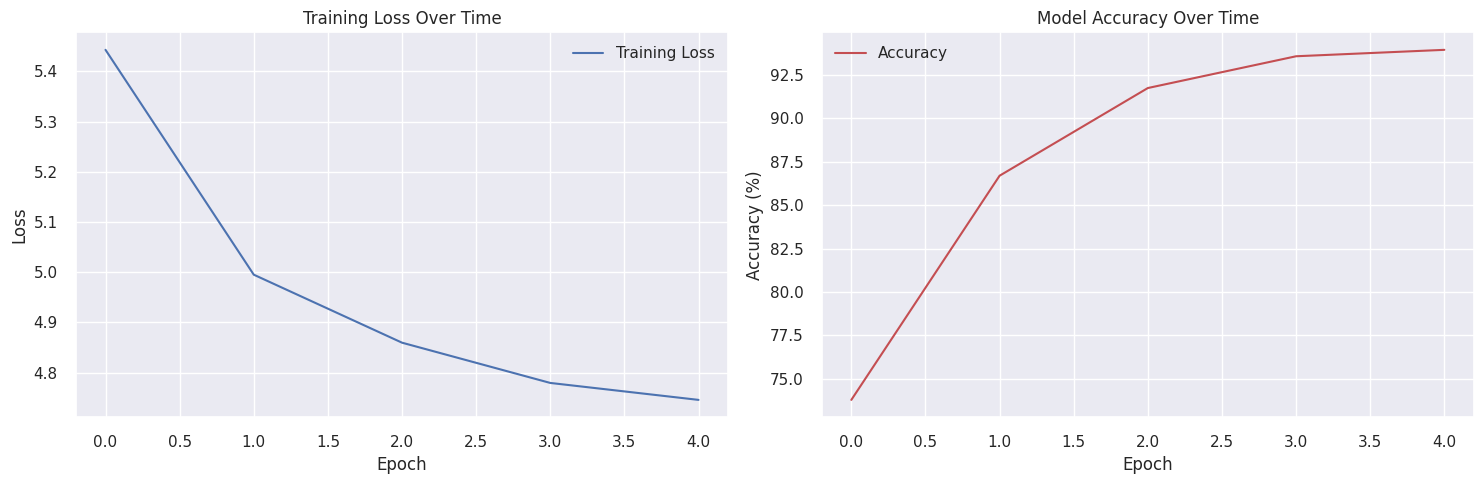

In [13]:
# Train the model
model, train_losses, accuracies = main()